In [ ]:
import PIL.Image as Image
import os
 
def start(Path):
    filelist = os.listdir(Path + 'JPEGImages/')
    for file in filelist:
        img = Image.open(Path + 'JPEGImages/' + file).convert('RGB')
        # print(img)
        img.save(Path + file)
    print('Done!')


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Grayscale
def BGR2GRAY(img):
    # Grayscale
    gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
    return gray

# Gabor Filter
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d
            # degree -> radian
            theta = angle / 180. * np.pi
            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py
            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py
            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# 使用Gabor滤波器作用于图像上
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)
        
    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# 使用6个不同角度的Gabor滤波器对图像进行特征提取
def Gabor_process(img):
    # get shape
    H, W, _ = img.shape

    # gray scale
    gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
        # gabor filtering
        _out = Gabor_filtering(gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)

        # add gabor filtered image
        out += _out

    # scale normalization
    out = out / out.max() * 255
    out = out.astype(np.uint8)

    return out

In [35]:
# Read image
img = cv2.imread("./palmprint.jpeg").astype(np.float32)
#img= cv2.imread("D:/数据库/风格迁移/star.jpg").astype(np.float32)
# gabor process
out = Gabor_process(img)

cv2.imwrite("out.jpg", out)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

<Figure size 432x288 with 0 Axes>

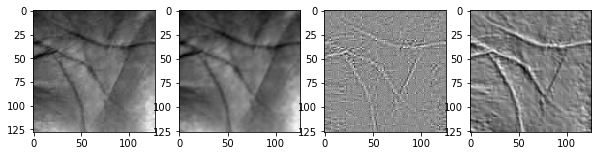

In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('./palmprint.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img0 = np.array(img).reshape(img.shape[0], img.shape[1], 1)
img = np.transpose(img0, (2, 0, 1))
img = img[np.newaxis, :]
inp = torch.Tensor(img)
# 三种常见的卷积核
conv1 = nn.Conv2d(1, 1, (3, 3))
conv2 = nn.Conv2d(1, 1, (3, 3))
conv3 = nn.Conv2d(1, 1, (3, 3))

# 高斯滤波
w1 = torch.Tensor(np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]]).reshape(1, 1, 3, 3))
# 边缘检测1
w2 = torch.Tensor(np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]).reshape(1, 1, 3, 3))
# 边缘检测2
w3 = torch.Tensor(np.array([[0, 1, 1], [-1, 0, 1], [-1, -1, 0]]).reshape(1, 1, 3, 3))
conv1.weight = nn.Parameter(w1)
conv2.weight = nn.Parameter(w2)
conv3.weight = nn.Parameter(w3)

out1 = conv1(inp).detach().numpy()
out2 = conv2(inp).detach().numpy()
out3 = conv3(inp).detach().numpy()
out1 = np.transpose(out1, (0, 2, 3, 1))
out2 = np.transpose(out2, (0, 2, 3, 1))
out3 = np.transpose(out3, (0, 2, 3, 1))

# 显示
plt.figure(figsize=(10, 5))
plt.subplot(141)
plt.imshow(img0.squeeze(), cmap="gray")
plt.subplot(142)
plt.imshow(out1.squeeze(), cmap='gray')
plt.subplot(143)
plt.imshow(out2.squeeze(), cmap='gray')
plt.subplot(144)
plt.imshow(out3.squeeze(), cmap='gray')
plt.show()